In [28]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.ensemble import (BalancedBaggingClassifier, BalancedRandomForestClassifier,
                               RUSBoostClassifier, EasyEnsembleClassifier)
from imblearn.metrics import classification_report_imbalanced
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics, svm
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_decision_regions
from collections import Counter

In [4]:
X,y =make_classification(n_samples=5000, n_features=6, n_informative=2, n_classes=3, n_clusters_per_class=1,
                        n_redundant=0,n_repeated=0,weights=[0.01,0.05,0.94],class_sep=0.8,random_state=0)
print("Dados em cada uma das classes",sorted(Counter(y).items()))
X.shape, y.shape

Dados em cada uma das classes [(0, 63), (1, 262), (2, 4675)]


((5000, 6), (5000,))

In [19]:
# funcão usada para imprimir a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Modelo imbalanced

### 1. Bagging Classifier

O método bagging faz uso de vários estimadores aplicados a diferentes amostras selecionadas aleatóriamente, mas acaba priorizando a classe com maior número de dados. Veja abaixo que treinamos o nosso "classificador" e depois testamos o mesmo para saber se obteve um bom resultado. Nosso conjunto de teste tem o seguinte número de dados em cada um das classes: classe0: 21, classe1: 55 e classe2: 1174. Ao aplicar o "classificador" nesse conjunto de dados obtemos como resultado um score de 0.93. A confusion matrix mostra que erramos pouco, com destaque para a previsão do resultado da classe 2.

In [14]:
# Bagging Classifier
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=0)
print("Dados para teste: ",sorted(Counter(y_test).items()))
bc=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0)
m1=bc.fit(x_train,y_train)
y_pred1=m1.predict(x_test)
print("Dados previstos: ",sorted(Counter(y_pred1).items()))
print("Score para BC usando Decision Tree:", balanced_accuracy_score(y_test,y_pred1))

Dados para teste:  [(0, 21), (1, 55), (2, 1174)]
Dados previstos:  [(0, 19), (1, 52), (2, 1179)]
Score para BC usando Decision Tree: 0.9310385431339435


In [34]:
print(classification_report_imbalanced(y_test,y_pred1))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      1.00      0.95      0.95      0.90        21
          1       0.94      0.89      1.00      0.92      0.94      0.88        55
          2       0.99      1.00      0.89      1.00      0.94      0.90      1174

avg / total       0.99      0.99      0.90      0.99      0.94      0.90      1250



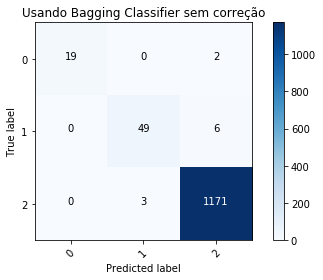

In [21]:
cm_tree = confusion_matrix(y_test, y_pred1)
plt.figure()
plot_confusion_matrix(cm_tree, classes=[0,1,2],
                      title='Usando Bagging Classifier sem correção')

## Corrigindo o imbalanced

Agora podemos tentar um outro classificador para fazer o rebalanceamento nas estimativas. Como primeiro exemplo, usamos o método "BalancedBaggingClassifier". Esse faz um "resample" de cada um dos subconjunto de dados da amostra para treinar cada um dos estimadores para depois combinar os resultados. Nesse caso, veja a diferença de classificação da classe0 e classe1 em relação ao primeiro método.

#### 1. Balanced Bagging Classifier

In [17]:
bbc=BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),sampling_strategy='auto',
                             replacement=False,random_state=0)
m2=bbc.fit(x_train,y_train)
y_pred2=m2.predict(x_test)
print("Dados para teste: ",sorted(Counter(y_test).items()))
print("Dados rebalanceados: ",sorted(Counter(y_pred2).items()))
print("Score para BBC usando Decision Tree:", balanced_accuracy_score(y_test,y_pred2))

Dados para teste:  [(0, 21), (1, 55), (2, 1174)]
Dados rebalanceados:  [(0, 61), (1, 168), (2, 1021)]
Score para BBC usando Decision Tree: 0.898866739922958


In [33]:
print(classification_report_imbalanced(y_test,y_pred2))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.31      0.90      0.97      0.46      0.93      0.87        21
          1       0.30      0.93      0.90      0.46      0.91      0.84        55
          2       0.99      0.86      0.92      0.92      0.89      0.79      1174

avg / total       0.95      0.87      0.92      0.90      0.89      0.80      1250



Confusion matrix, without normalization


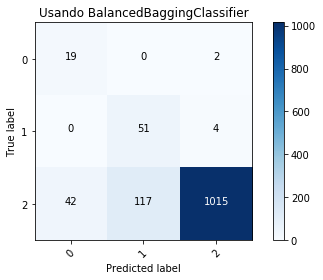

In [18]:
cm_tree2 = confusion_matrix(y_test, y_pred2)
plt.figure()
plot_confusion_matrix(cm_tree2, classes=[0,1,2],
                      title='Usando BalancedBaggingClassifier')

#### 2. Forest of Randomized Trees
No método ensemble usado a seguir cada uma das árvores da floresta tem uma amostra que é balanceada via bootstrap.

In [22]:
brf=BalancedRandomForestClassifier(n_estimators=100,random_state=0,sampling_strategy='auto', 
                                   replacement=False, n_jobs=1,warm_start=True)
m3=brf.fit(x_train,y_train)
y_pred3=m3.predict(x_test)
print("Dados para teste: ",sorted(Counter(y_test).items()))
print("Dados rebalanceados: ",sorted(Counter(y_pred3).items()))
print("Score para BC usando Decision Tree:", balanced_accuracy_score(y_test,y_pred3))

Dados para teste:  [(0, 21), (1, 55), (2, 1174)]
Dados rebalanceados:  [(0, 38), (1, 163), (2, 1049)]
Score para BC usando Decision Tree: 0.8162289726173882


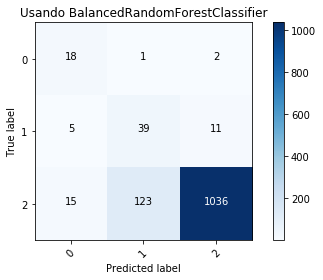

In [24]:
cm_tree3 = confusion_matrix(y_test, y_pred3)
plt.figure()
plot_confusion_matrix(cm_tree3, classes=[0,1,2],
                      title='Usando BalancedRandomForestClassifier')

#### 3. RUSBoostClassifier

In [25]:
rus=RUSBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, learning_rate=1.0, 
                       algorithm='SAMME.R', sampling_strategy='auto', replacement=False, random_state=0)
m4=rus.fit(x_train,y_train)
y_pred4=m4.predict(x_test)
print("Dados para teste: ",sorted(Counter(y_test).items()))
print("Dados rebalanceados: ",sorted(Counter(y_pred4).items()))
print("Score para BC usando Decision Tree:", balanced_accuracy_score(y_test,y_pred4))

Dados para teste:  [(0, 21), (1, 55), (2, 1174)]
Dados rebalanceados:  [(0, 18), (1, 203), (2, 1029)]
Score para BC usando Decision Tree: 0.7133247785717973


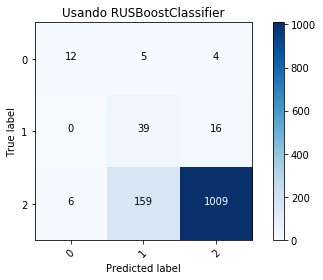

In [26]:
cm_tree4 = confusion_matrix(y_test, y_pred4)
plt.figure()
plot_confusion_matrix(cm_tree4, classes=[0,1,2],
                      title='Usando RUSBoostClassifier')

#### 4. EasyEnsembleClassifier

In [31]:
eec=EasyEnsembleClassifier(n_estimators=100, base_estimator=AdaBoostClassifier(), warm_start=True, 
                           sampling_strategy='auto', replacement=False, n_jobs=1, random_state=0, verbose=0)
m5=eec.fit(x_train,y_train)
y_pred5=m5.predict(x_test)
print("Dados para teste: ",sorted(Counter(y_test).items()))
print("Dados rebalanceados: ",sorted(Counter(y_pred5).items()))
print("Score para BC usando Decision Tree:", balanced_accuracy_score(y_test,y_pred5))

Dados para teste:  [(0, 21), (1, 55), (2, 1174)]
Dados rebalanceados:  [(0, 391), (1, 83), (2, 776)]
Score para BC usando Decision Tree: 0.7937921438773228


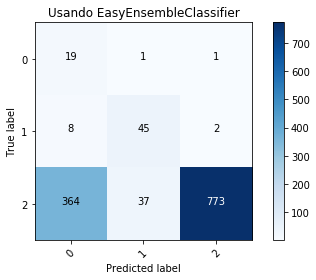

In [32]:
cm_tree5 = confusion_matrix(y_test, y_pred5)
plt.figure()
plot_confusion_matrix(cm_tree5, classes=[0,1,2],
                      title='Usando EasyEnsembleClassifier')

Uma boa discussão sobre o tema pode ser vista em:
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/ 